# DCGAN

В этом уроке мы увидим как можно обучать GAN для генерации изображений. А начнем мы с известного по прошлым модулям датасета -- FashionMNIST.

БОльшая часть кода не изменилась с прошлого двумерного случая! Мы должны поменять архитектуры генератора и дискриминатора, чтобы они лучше соответствовали задаче генерации изображений.

В качестве основной архитектуры мы будем использовать DCGAN. Ниже приведем иллюстрацию архитектуры, которую мы и реализум с небольшими изменениями ( [источник](https://github.com/znxlwm/tensorflow-MNIST-GAN-DCGAN) иллюстрации).

![alt text](https://github.com/znxlwm/tensorflow-MNIST-GAN-DCGAN/raw/master/tensorflow_DCGAN.png)


Вы можете обратить внимание что это классический энкодер (дискриминатор) и декодер (генератор). Первый уменьшает картинку, вычисляя все более полезные признаки и наконец предсказывая ответ -- real/fake. А второй -- превращает 100 размерный вектор в картинку 32x32.

То, что написано справа на иллюстрации -- параметры с которыми DCGAN показывает себя наиболее стабильным. Они были получены эмпирически. Т.к. GAN очень капризные в плане обучения -- рекомендую им следовать. Еще больше лайфхаков здесь: https://github.com/soumith/ganhacks .

В схеме присутствует несколько незнакомых слов, а именно Tanh, LeakyReLU, Batch Normalization. Остановимся на них чуть подробнее.

### Tanh, LeakyReLU

**Tanh** -- активация, похожая на сигмоиду, только превращает предсказания в промежуток -1, 1.

<img src="http://ronny.rest/media/blog/2017/2017_08_16_tanh/tanh_v_sigmoid.jpg" width=300>

Мы будем кодировать значения пикселей значениями от -1 до 1 (почему то GAN так работает лучше). Поэтому и генерировать изображения нужно в этом промежутке -- поэтому в последнем слое генератора мы будем использовать эту функцию. 

**LeakyReLU** -- аналог ReLU, но не так строг по отношению к отрицательным значениям.

<img src="https://qph.fs.quoracdn.net/main-qimg-68345231be6cb497732a056a51868d98"  width=400>

Используется во всех слоях. Опять же потому что эмпирически показано, что в GAN они демонстрируют лучшее качество.

### Batch Normalization

Batch Normalization -- один из способов улучшения сходимости нейронных сетей. Вы уже знаете, что перед тем как данных поступают в нейронную сеть их нужно нормализовать. Один из способов такой нормализации -- вычитание среднего и деление на дисперсию. Оказывается, что нормализовать признаки полезно не только на входе -- но и после каждого слоя. Это и делает Batch Normalization. Он нормализует выход слоя к которому он применен, при этом во время обучения он "запоминает" среднее и дисперсию, которое он привык видеть -- и использует его во время инференса.

Более глубокое понимание в этом уроке нам не пригодится. Если хотите ознакомиться подробнее -- можете изучить материал по [ссылке](https://www.learnopencv.com/batch-normalization-in-deep-networks/) или на [русском](http://neerc.ifmo.ru/wiki/index.php?title=Batch-normalization).


### Модификации

Мы будем обучать модель чуть меньше. Во-первых, мы будем работать с картинкой размера 32x32 (а не 64x64). А так же вместо размерностей каналов 1024->512->256->128, мы будем работать с 256->128->64. Можно сделать сеть чуть легче потому что мы будем работать с более "простыми" данными.

А также вместо "Deconv" или TransposedConv, для увеличения размера сигнала будем использовать UpScale + Conv. Это позволяет уменьшить количество артифактов на сгенерированных изображениях

In [ ]:
import tensorflow as tf
tf.enable_eager_execution()

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time
from IPython import display
from tqdm import tqdm_notebook as tqdm
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import UpSampling2D, Conv2D, BatchNormalization, LeakyReLU, Conv2DTranspose, Reshape, Flatten


cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
init = RandomNormal(mean=0.0, stddev=0.02)

In [ ]:
class DCGAN(tf.keras.Model):

    def __init__(self, image_size, output_path, num_channels=1, z_dim=128,
                 G_h_size=128, D_h_size=128, batch_size=256):
        super().__init__()
        self.image_size = image_size
        self.num_channels = num_channels
        self.z_dim = z_dim

        self.output_path = output_path

        self.G_h_size = G_h_size
        self.D_h_size = D_h_size

        self.generator = self._build_generator()
        self.discriminator = self._build_discriminator()

        self.optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5, beta_2=0.999)

        self.batch_size = batch_size
        self._vis_h = 5
        self._vis_w = 5
        self._vis_noise = np.random.normal(0, 1, (self._vis_h* self._vis_w, self.z_dim)).astype(np.float32)

    def discriminator_loss(self, real_output, fake_output):
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_loss(self, fake_output):
        return cross_entropy(tf.ones_like(fake_output), fake_output)
    
    def _conv_bn_leaky(self, kernel_size, channels, stride=1):
        """
        Этот блок мы будем часто использовать -- поэтому вынесем его в отдельную функцию

        Он содержит Conv + BatchNorm + LeakyReLU

        При указании stride=2 -- уменьшит размер в два раза.
        """
        model = tf.keras.Sequential()
        model.add(Conv2D(channels,
                         kernel_size=kernel_size, padding="same",
                         use_bias=False, kernel_initializer=init,
                         strides=(stride, stride))) # use_bias=False, т.к. BatchNorm и так вычтет среднее
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        return model
        

    def _build_generator(self):
        """
        Генератор должен превращать вектор длины self.z_dim в 
        картинку 32x32x1

        """
        model = tf.keras.Sequential()
        # для начала сделаем вектор -- трехмерным тензором м помощью Reshape
        model.add(Reshape((1, 1, self.z_dim), input_shape=(self.z_dim,)))

        # Превратим его в тензор размера (4, 4, self.G_h_size * 4)
        model.add(Conv2DTranspose(self.G_h_size * 4,
                                  kernel_size=4, use_bias=False, 
                                  kernel_initializer=init))
        model.add(BatchNormalization())
        model.add(LeakyReLU())

        upsamples_num = int(np.log2(self.image_size / 8)) # столько раз применим апсемплинг в цикле, 
                                                          # чтобы из (4,4) получить (image_size/2, image_size/2)
                                                          # в нашем случае -- 2 (image_size=32)
        
        for i in range(upsamples_num):
            model.add(UpSampling2D()) # увеличиваем картинку
            model.add(self._conv_bn_leaky(4, self.G_h_size * 4 // 2**(i+1))) # уменьшаем количество фильтров в два раза
            
        model.add(UpSampling2D())
        model.add(Conv2D(self.num_channels,
                         kernel_size=4, strides=(1, 1),
                         activation="tanh", padding="same", 
                         kernel_initializer=init))
        return model

    def _build_discriminator(self):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.InputLayer(
            input_shape=((self.image_size, self.image_size, self.num_channels))))
        model.add(self._conv_bn_leaky(kernel_size=4, 
                                      channels=self.D_h_size,
                                      stride=2,
                                      ))
        
        downsamples_num = int(np.log2(self.image_size / 8)) # столько раз применим доунсэмплинг в цикле, 
                                                          # чтобы из (image_size/2, image_size/2) получить (4,4) 
        for i in range(downsamples_num):
            model.add(self._conv_bn_leaky(kernel_size=4, 
                                          channels=self.D_h_size * (2 ** (i+1)),
                                          stride=2)) # количество фильтров увеличивается, размер уменьшается
        
        # после цикла получили тензор размера (4, 4, 256), значит свернув его с ядром (4,4,256,1) -- получим число
        model.add(Conv2D(1, kernel_size=4, kernel_initializer=init)) # без активации !
        model.add(Flatten())
        return model
    
    @tf.function
    def train_step(self, images):
        """
        Шаг обучения как в прошлом уроке
        """
        noise = tf.random.normal([tf.cast(images.shape[0], tf.int32), self.z_dim])
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)
            
        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

    def save_imgs(self, epoch):
        """
        Сохранение промежуточных картинок на диск
        """
        gen_imgs = self.generator(self._vis_noise, training=False)
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(self._vis_h, self._vis_w, figsize=(6,6))
        cnt = 0
        for i in range(self._vis_h):
            for j in range(self._vis_w):
                if self.num_channels == 1:
                    axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                else:
                    axs[i, j].imshow(gen_imgs[cnt, :, :, :])
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig(self.output_path / f"mnist_{epoch}.png")
        plt.show()
    
    def train(self, dataset, epochs):
        """
        Цикл обучения
        """
        for epoch in range(epochs):
            start = time.time()
            iters = 0
            for image_batch in tqdm(dataset):
                self.train_step(image_batch)
                iters += 1
                if iters % 100 == 0:
                    display.clear_output(wait=True)
                    self.save_imgs(f"{epoch}:{iters}")
            
            display.clear_output(wait=True)
            self.save_imgs(epoch)
            
            print(f'Time for epoch {epoch} is {time.time() - start} sec')

In [ ]:
output = Path("images_mnist3")
output.mkdir(exist_ok=True)
BATCH_SIZE = 256
IMAGE_SIZE = 32
EPOCHS = 20
gan = DCGAN(image_size=IMAGE_SIZE, num_channels=1, output_path=output, 
           z_dim=100, D_h_size=64, G_h_size=64)

In [ ]:
gan.generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1, 1, 100)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 256)         409600    
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 4, 256)         1024      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4, 4, 256)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 256)         0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 8, 8, 128)         524800    
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 128)       0

In [ ]:
gan.discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 16, 16, 64)        1280      
_________________________________________________________________
sequential_5 (Sequential)    (None, 8, 8, 128)         131584    
_________________________________________________________________
sequential_6 (Sequential)    (None, 4, 4, 256)         525312    
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 1, 1, 1)           4097      
_________________________________________________________________
flatten (Flatten)            (None, 1)                 0         
Total params: 662,273
Trainable params: 661,377
Non-trainable params: 896
_________________________________________________________________


In [ ]:
def generate_data(latent_vector, generator):
    """
    Для того чтобы сгенерировать объект нам нужен генератор и латентный вектор
    """
    gen_imgs = generator(latent_vector, training=False)
    gen_imgs = 0.5 * gen_imgs + 0.5
    return gen_imgs

Вектор:  [-0.24265815  0.6551022   0.43294355  0.29846755 -0.19041432  0.28916508
  0.6164831  -2.3312933   1.5683995  -1.0533694 ]


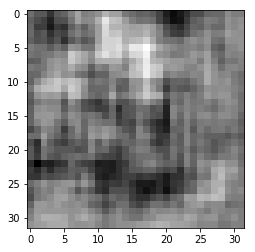

In [ ]:
v1 = tf.random.normal([1, 100]) # случайный вектор
print("Вектор: ", v1.numpy()[0, :10]) # распечатаем 10 первых элементов
_ = plt.imshow(generate_data(v1, gan.generator)[0, ..., 0], cmap="gray") # ган не обучен -- получим что-то непонятное

In [ ]:
# Подготовим данные. 
# 1. Увеличим картинки до 32x32 -- в целях более удобного деления на 2
# 2. Преобразуем яркости из 0..255 в -1..1
# 3. Используя функции tensorflow превратим датасет в итератор по батчам. (раньше за нас это делал Keras)

(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = tf.image.resize(train_images, (32, 32), tf.image.ResizeMethod.NEAREST_NEIGHBOR)

train_images = (train_images - 127.5) / 127.5 
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)

In [ ]:
# создав датасет таким образом, мы можем теперь итерироваться по нему так
for img in train_dataset.take(4):
    print(img.shape) # но он возвращает только одну картинку за раз

(32, 32, 1)
(32, 32, 1)
(32, 32, 1)
(32, 32, 1)


In [ ]:
# разобьем его на батчи и перемешаем (BUFFER_SIZE -- параметр перемешивания, обычно равен размеру датасета)
BUFFER_SIZE = 60000

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
for img in train_dataset.take(4):
    print(img.shape) # теперь итерирование происходит по батчам

(256, 32, 32, 1)
(256, 32, 32, 1)
(256, 32, 32, 1)
(256, 32, 32, 1)


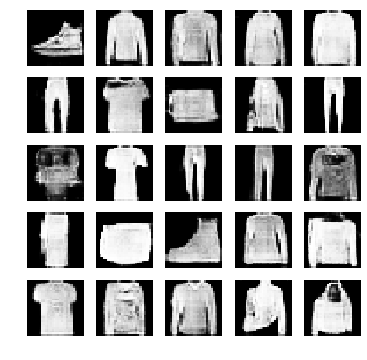

Time for epoch 19 is 52.00587844848633 sec


In [ ]:
gan.train(train_dataset, EPOCHS) # занимает около 20 минут -- эпоха в минуту

In [ ]:
import imageio
filenames = sorted(list(output.glob("*:*.png")), key=lambda x: int(x.name.split(":")[0].split("_")[1]))
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('movie.gif', images, duration=0.2)

# Генерация данных

Вектор:  [-0.18205163 -0.27130106  0.37788385 -0.1466595  -0.7747912  -0.10410172
 -1.589122    1.2000412   0.71668494 -1.482601  ]


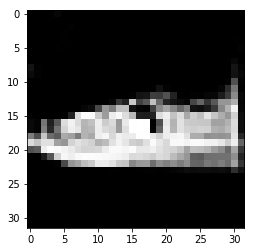

In [ ]:
v1 = tf.random.normal([1, 100]) # случайный вектор
print("Вектор: ", v1.numpy()[0, :10]) # распечатаем 10 первых элементов
_ = plt.imshow(generate_data(v1, gan.generator)[0, ..., 0], cmap="gray")

 # Интерполяция

Т.к. наши картинки генерируются из векторов, то мы можем производить с ними различные векторные операции. Посчитать среднее:

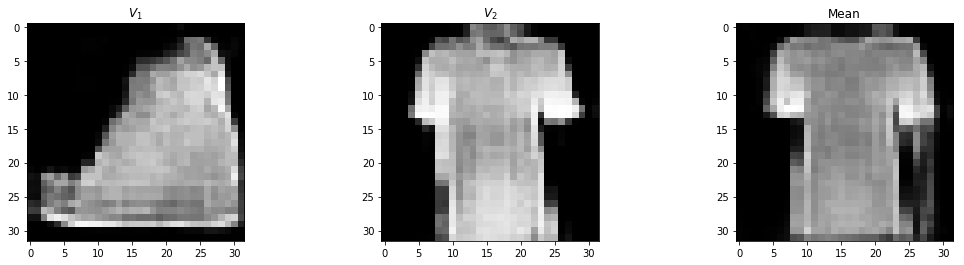

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18,4))
v1 = tf.random.normal([1, 100])
v2 = tf.random.normal([1, 100])
mean_vec = (v1+v2)/2.

for ax, vec, name in zip(axs, [v1, v2, mean_vec], ["$V_1$", "$V_2$", "Mean"]):
    image = generate_data(vec, gan.generator)[0, ..., 0]
    ax.imshow(image, cmap='gray')
    ax.set_title(name)

Или вместо среднего мы можем "смешать" их в разных пропорциях. Или интерполировать. Т.е. превратить один вектор в другой. А значит и одну картинку в другую!

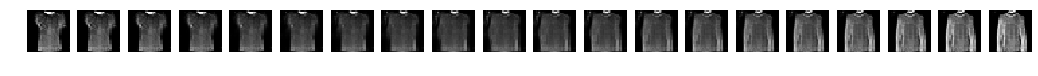

In [ ]:
v1 = tf.random.normal([1, 100])
v2 = tf.random.normal([1, 100])

n = 20
fig, axs = plt.subplots(1, n, figsize=(18,4))
for i, alpha in enumerate(np.linspace(0, 1, n)):
    curr_vec = v1 * (1-alpha) + v2 * alpha
    image = generate_data(curr_vec, gan.generator)[0, ..., 0]
    axs[i].imshow(image, cmap='gray')
    axs[i].axis('off')

# Заключение
В этом уроке мы реализовали и успешно обучили DCGAN. В домашнем задании вас ждет похожая но более сложная задача -- научиться генерировать лица людей!